In [1]:
#zDependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta 

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

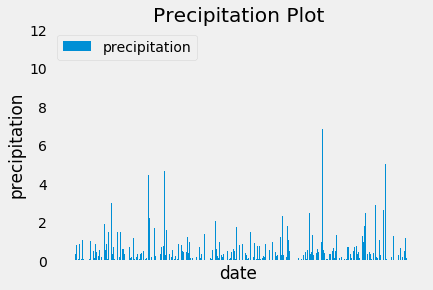

In [27]:
engine.table_names()
dates = pd.read_sql_query('select date,prcp from Measurement ORDER BY date desc', con=engine)
dates = pd.to_datetime(dates['date'],format ='%Y-%m-%d')
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_year = pd.read_sql_query("select * from measurement WHERE date BETWEEN '2016-07-23' AND '2017-07-23'",con=engine)
#Calculate the date 1 year ago from the last data point in the database
year_ago = dates[0] - timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
combined_df = pd.read_sql_query("SELECT * FROM Measurement JOIN Station ON (Measurement.station = Station.station)",con = engine)
# Save the query results as a Pandas DataFrame and set the index to the date column
combined_df = combined_df.sort_values(by=['date'])
combined_df = combined_df.set_index('date')
# Use Pandas Plotting with Matplotlib to plot the data
x = combined_df.index.tolist()
y = combined_df['prcp'].tolist()
plt.bar(x,y,label='precipitation')
plt.tick_params(
    axis='x',         
    which='both',     
    bottom=False,      
    top=False,        
    labelbottom=False)
ticks = np.arange(0,300,50)
plt.xticks(ticks)
plt.title('Precipitation Plot')
plt.xlabel("date")
plt.ylabel("precipitation")
plt.grid()
plt.legend()
plt.show()

![precipitation](Images/precipitation.png)

In [28]:
# Use pandas to calculate the summary statistics for the percipitation data
combined_df.describe()

,id,prcp,tobs,id,latitude,longitude,elevation
count,19550.000000,18103.000000,19550.000000,19550.000000,19550.000000,19550.000000,19550.000000
mean,9775.500000,0.160644,73.097954,4.989719,21.382151,-157.839901,39.858363
std,5643.743217,0.468746,4.523527,2.783865,0.079017,0.085735,64.987876
min,1.000000,0.000000,53.000000,1.000000,21.271600,-158.011100,0.900000
25%,4888.250000,0.000000,70.000000,2.000000,21.333100,-157.848890,7.000000
50%,9775.500000,0.010000,73.000000,6.000000,21.335560,-157.816800,14.600000
75%,14662.750000,0.110000,76.000000,7.000000,21.451670,-157.801500,32.900000
max,19550.000000,11.530000,87.000000,9.000000,21.521300,-157.711390,306.600000


![describe](Images/describe.png)

In [10]:
# Design a query to show how many stations are available in this dataset?
unique_stations = pd.read_sql_query("SELECT COUNT(DISTINCT station) FROM Station",con = engine)

,id,station,prcp,tobs,id,station,name,latitude,longitude,elevation
date,,,,,,,,,,
2010-01-01,1,USC00519397,0.08,65.0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2010-01-01,9008,USC00518838,0.21,72.0,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order
station_counts = pd.read_sql_query("SELECT station, COUNT(1) AS count FROM Measurement GROUP BY station ORDER BY count DESC;", con = engine)
station_counts = station_counts.sort_values(by = 'count', ascending = False)

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_count = station_counts['count'].max()
unique_index = pd.Index(station_counts['count'])
index = unique_index.get_loc(max_count)
max_station = station_counts['station'][index]
max_station

'USC00519281'

In [13]:
max_temp = pd.read_sql_query("SELECT MAX(tobs) FROM Measurement Where station = 'USC00519281';",con = engine)
min_temp = pd.read_sql_query("SELECT MIN(tobs) FROM Measurement Where station = 'USC00519281';",con = engine)
avg_temp = pd.read_sql_query("SELECT AVG(tobs) FROM Measurement Where station = 'USC00519281';",con = engine)

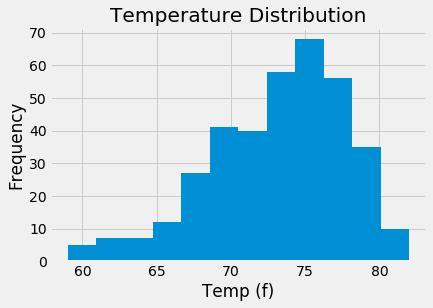

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_max_station = pd.read_sql_query("select * from measurement WHERE date BETWEEN '2016-07-23' AND '2017-07-23' AND station = 'USC00519281' ",con=engine)
last_year_max_station.tail()


plt.hist(last_year_max_station['tobs'], bins = 12)
plt.xlabel('Temp (f)')
plt.ylabel('Frequency')
plt.title('Temperature Distribution')
plt.show()


![precipitation](Images/station-histogram.png)

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = '2017-03-01'
end = '2017-03-07'
results = calc_temps(start,end)[0]
results

(62.0, 71.02380952380952, 78.0)

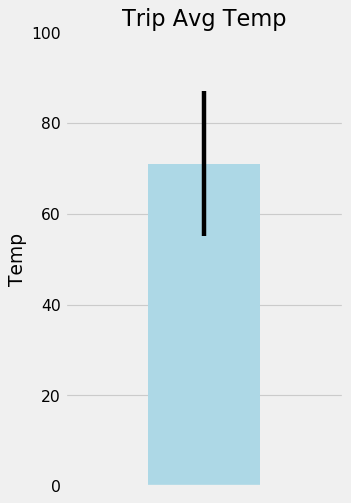

In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [results[1]]
error = [(results[2] - results[0])]
plt.figure(figsize=(4, 7), dpi=80)
plt.bar(x_pos,y_pos,color='lightblue', yerr=error)
plt.xlim(-1,1)
plt.title("Trip Avg Temp")
plt.ylabel("Temp")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major',axis='x',linestyle='')

plt.show()

In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_year_before = pd.to_datetime(start,format = '%Y-%m-%d') - timedelta(days=365)
end_year_before = pd.to_datetime(end,format = '%Y-%m-%d') - timedelta(days=365)
is_greater =pd.to_datetime(combined_df.index,format = '%Y-%m-%d') >= start_year_before
year_before = combined_df[is_greater]
is_less = pd.to_datetime(year_before.index,format = '%Y-%m-%d') <= end_year_before
year_before = year_before[is_less]
year_before = year_before.ix[:,~year_before.columns.duplicated()]
year_before['prcp'].sum()
stations = year_before.groupby(['station']).sum()
station_prcp = stations.sort_values(by='prcp', ascending = False)
station_prcp

C:\Users\brian\Anaconda4\envs\PythonData\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
C:\Users\brian\Anaconda4\envs\PythonData\lib\site-packages\pandas\core\indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,id,prcp,tobs,latitude,longitude,elevation
station,,,,,,
USC00519523,81823,0.33,496.0,149.34892,-1103.97973,136.5
USC00514830,50274,0.07,516.0,150.64910,-1104.86180,49.0
USC00516128,95230,0.02,341.0,106.66550,-789.01250,762.0
USC00519281,101052,0.01,469.0,150.16169,-1104.94223,230.3
USC00513117,34433,0.00,488.0,149.96380,-1104.61050,102.2
USC00517948,43610,0.00,346.0,106.96700,-789.87550,59.5
USC00519397,15344,0.00,475.0,148.90120,-1104.71760,21.0
